In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np 
from numpy import log
import gmaps 
import gmaps.datasets 
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('ggplot')
from sorted_months_weekdays import Month_Sorted_Month

from statsmodels.compat.pandas import Appender

import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tools.data import _is_using_pandas
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.statespace.kalman_filter import MEMORY_CONSERVE
from statsmodels.tsa.statespace.tools import diff
import statsmodels.base.wrapper as wrap
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.estimators.yule_walker import yule_walker
from statsmodels.tsa.arima.estimators.burg import burg
from statsmodels.tsa.arima.estimators.hannan_rissanen import hannan_rissanen
from statsmodels.tsa.arima.estimators.innovations import (
    innovations, innovations_mle)
from statsmodels.tsa.arima.estimators.gls import gls as estimate_gls

from statsmodels.tsa.arima.specification import SARIMAXSpecification
import statsmodels.api
import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

import itertools

from pmdarima.utils import diff_inv

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h4>Load diffed and undiffed electrical consumption data</h4>

In [3]:
# load stationary consumption data from EDA notebook (diffed 2x)
diffed = pd.read_csv('stationary-data/diffed_data.csv').set_index('Date')

In [4]:
# load undiffed consumption data from EDA notebook (not diffed)
cov_rem = pd.read_csv('stationary-data/cov_rem.csv').set_index('Date')

<h4>Perform Trend-Seasonal-Residual decomposition</h4>

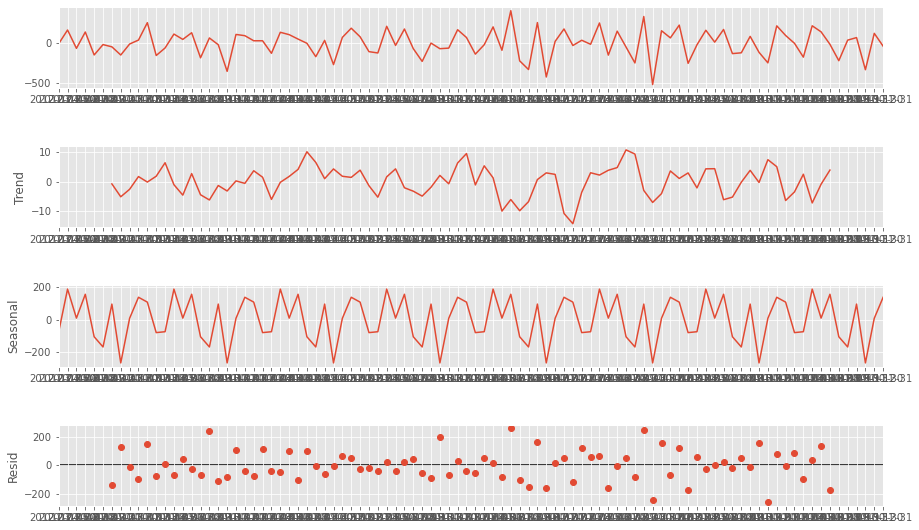

In [5]:
res = sm.tsa.seasonal_decompose(diffed,period=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.savefig('images/seas_decomp_diffed.png')

<h4>Split the data into training and testing sets</h4>

In [21]:
#train_test_split 
# tr_start,tr_end = '2012-03-31','2018-05-31'
# te_start,te_end = '2018-06-30','2020-01-31'
train = diffed[0:73]
test = diffed[74:]

<h4>Scope the AR (p) and MA (q) terms with ACF plot</h4>

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


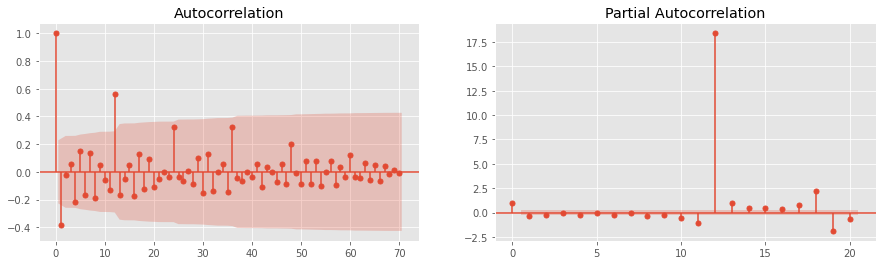

In [7]:
# SARIMAX AC and PAC 

fig, ax = plt.subplots(1, 2, figsize=(15,4))
fig = sm.graphics.tsa.plot_acf(train, lags=70, ax=ax[0])

fig = sm.graphics.tsa.plot_pacf(train, lags=20, ax=ax[1])
#plt.show()
plt.savefig('images/AC_PAC_functions.png')

<h4>Run gridsearch to find optimal parameters</h4>

In [8]:
# Find optimized parameters for SARIMAX diffed
def grid_search(train):

    #set parameter range
    p = range(0,3)
    q = range(1,3)
    d = range(1,2)
    
    # seasonal parameters
    P = range(0,3)
    Q = range(1,3)
    D = range(1,3)
    S = range(12,13)
    
    maxiter=50
    
    # list of all parameter combos
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, S))
    

    ans = []
    
    # SARIMA model pipeline
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train,
                                        order=param,
                                        seasonal_order=param_seasonal)
                
                
                output = mod.fit(maxiter=maxiter) 
                ans.append([param, param_seasonal, output.aic])
                'SARIMAX{},{} - AIC:{}'.format(param, param_seasonal, output.aic)
            except Exception as e:
                print(e)
                continue
    # Find the parameters with minimal AIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:5]

    return ans_df

In [9]:
grid_search(train)

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no asso

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be igno

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be igno

LU decomposition error.


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LU decomposition error.


/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/k

,pdq,pdqs,aic
22,"(0, 1, 2)","(2, 2, 1, 12)",627.256549
15,"(0, 1, 2)","(0, 2, 2, 12)",628.306730
14,"(0, 1, 2)","(0, 2, 1, 12)",629.558011
39,"(1, 1, 2)","(0, 2, 2, 12)",630.282205
18,"(0, 1, 2)","(1, 2, 1, 12)",630.316671


In [38]:
# # SARIMAX AC and PAC with optimized parameters
# # (0, 1, 2)(0, 2, 1, 12)
# mod = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 2), seasonal_order=(0, 2, 1, 12)).fit(max_iter=50, method='powell')

# resid = mod.resid

# fig, ax = plt.subplots(1, 2, figsize=(15,4))
# fig = sm.graphics.tsa.plot_acf(resid, lags=70, ax=ax[0])

# fig = sm.graphics.tsa.plot_pacf(resid, lags=35, ax=ax[1])
# #plt.show()
# plt.savefig('images/AC_PAC_functions.png')

<h4>Train model on training set</h4>

In [11]:
# SARIMA with optimized parameters
mod = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 2), seasonal_order=(2, 2, 1, 12), simple_differencing=True)
res = mod.fit(max_iter=50)
res
print(res.summary())

# (0, 1, 2), seasonal_order=(2, 1, 1, 4)
# SARIMAX(0, 1, 2),(1, 1, 2, 6) - AIC:832.7026273809294
# (0, 1, 2)(0, 2, 1, 12)

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                      SARIMAX Results                                       
Dep. Variable:               D.D2S12.avg_kwh_capita   No. Observations:                   49
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                -309.189
Date:                              Tue, 12 Jan 2021   AIC                            630.378
Time:                                      15:53:41   BIC                            641.729
Sample:                                           0   HQIC                           634.684
                                               - 49                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9828      3.873     -0.512      0.609      -9.574       5.609
ma.L2          0.98

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<h4>Generate in-sample predictions from model</h4>

In [12]:
# generate in-sample predictions 
predictions = res.predict(start=76, end=95)

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [13]:
predictions.head()

76    -23.241172
77   -106.723852
78     17.553183
79     64.618042
80   -136.950879
Name: predicted_mean, dtype: float64

In [14]:
cov_rem['avg_kwh_capita'].head()

Date
2012-01-31    1000.127850
2012-02-28     956.367278
2012-03-31     907.091925
2012-04-30    1023.898229
2012-05-31    1076.980665
Name: avg_kwh_capita, dtype: float64

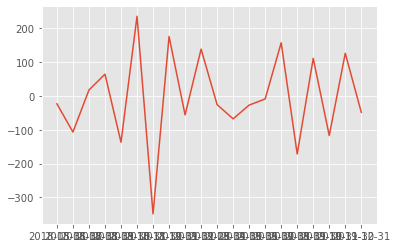

In [22]:
# plot r

predictions = pd.DataFrame(predictions)
predictions.index = test.index

x = predictions.index

fig, ax = plt.subplots()
ax.plot(x, predictions)

<AxesSubplot:xlabel='Date'>

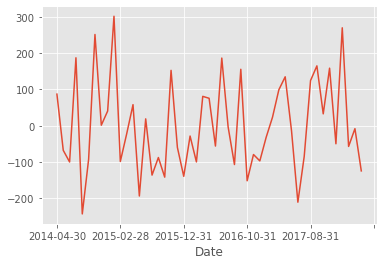

In [23]:
# plot residuals
res.resid.plot()
# residuals = pd.DataFrame(residuals)

# x = residuals.index

# fig, ax = plt.subplots()
# ax.plot(x, residuals)

<h4>Generate inverse diff data for actual and predicted data</h4>

In [24]:
def inv_diff(res, orig_column, diff_column, periods):
    # generate predictions (diffed)
    predictions = res.predict(start=76, end=95)

    # Generate np.array for the diff_inv function - it includes first n values(n = 
    # periods) of original data & further diff values of given periods
    value = np.array(orig_column[:periods].tolist() +
                     diff_column[periods:].tolist())

    # Generate np.array with inverse diff
    inv_diff_vals = diff_inv(value, periods, 1)[periods:]
    return inv_diff_vals

In [151]:
# def inv_diff(df_orig_column ,df_diff_column, periods):
#     # Generate np.array for the diff_inv function - it includes first n values(n = 
#     # periods) of original data & further diff values of given periods
#     value = np.array(df_orig_column[:periods].tolist() + df_diff_column[periods:].tolist())
#     print(value)
#     # Generate np.array with inverse diff
#     inv_diff_vals = diff_inv(value, periods,1)[periods:]
#     return inv_diff_vals

In [25]:
undiffed_preds = inv_diff(res, cov_rem['avg_kwh_capita'], predictions, 12)

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


AttributeError: 'DataFrame' object has no attribute 'tolist'

In [26]:
undiffed_preds = pd.DataFrame(undiffed_preds)

NameError: name 'undiffed_preds' is not defined

#### Plot autocorrelations of residuals to see if they're within the conf int

In [160]:
# # SARIMAX AC and PAC with optimized parameters
# # mod = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 2), seasonal_order=(1, 1, 2, 6)).fit(max_iter=50)

# resid = mod.resid

# fig, ax = plt.subplots(1, 2, figsize=(15,4))
# fig = sm.graphics.tsa.plot_acf(resid, lags=70, ax=ax[0])

# fig = sm.graphics.tsa.plot_pacf(resid, lags=35, ax=ax[1])
# #plt.show()
# plt.savefig('images/AC_PAC_functions.png')

<h4>Plot test data with predicted data</h4>

In [195]:
# create a data frame with predicted and actual values of undiffed data
undiffed_preds.reset_index(drop=True, inplace=True)
undiffed_preds.index=predictions.index
undiffed_preds['actual'] = cov_rem['avg_kwh_capita'][77:97]
undiffed_preds.head()
undiffed_preds.columns = ['predicted_mean', 'actual']

In [198]:
# # plot test and pred data without differencing to see original unit scale
# # revisit to figure out what's going

# undiffed_preds['actual'].plot(figsize=(20,8), legend=True, linewidth=3.0)
# undiffed_preds['predicted_mean'].plot(legend=True, linewidth=3.0, figsize=(20,8))

# ax.set_title("Model Fit with Test Data", fontsize=18)
# ax.set_xlabel('Date', fontsize='x-large')
# ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
# plt.legend(['Observed', 'Predicted'], loc=3, fontsize='large')

# # revisit to investigate prediction values being off by 6 months 
# plt.savefig('images/test_pred_plot.png')

#### Train model using full dataset

In [27]:
# SARIMA with optimized parameters
mod_full = sm.tsa.statespace.SARIMAX(cov_rem, order=(0, 1, 2), seasonal_order=(2, 2, 1, 12), simple_differencing=False)
res_full = mod.fit(max_iter=50)
res_full
#print(res.summary())

#(0, 1, 2)(2, 2, 1, 12)627.256549

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


#### Generate df for plotting forecast in Dash

In [28]:
predictions_full = res_full.predict(start=0, end=276)
predictions_full = pd.DataFrame(predictions_full)
#predictions_full.index = future_kwh.index

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [69]:
def inv_diff(df_orig_column ,df_diff_column, periods):
    # generate predictions (diffed)
    predictions_full = res_full.predict(start=0, end=276)

    # Generate np.array for the diff_inv function - it includes first n values(n = 
    # periods) of original data & further diff values of given periods
    value = np.array(df_orig_column[:periods].tolist() +
                     df_diff_column[periods:].tolist())

    # Generate np.array with inverse diff
    inv_diff_vals = diff_inv(value, periods, 1)[periods:]
    return inv_diff_vals

In [70]:
undiffed_preds_full = inv_diff(cov_rem['avg_kwh_capita'], predictions_full['predicted_mean'], 12)

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [71]:
# undiffed = 277
undiffed_preds_full = pd.DataFrame(undiffed_preds_full)

In [72]:
# Create a dataframe with index length of my prediction 
future_kwh_full = pd.DataFrame()
future_kwh_full.index = pd.to_datetime(future_kwh_full.index, infer_datetime_format=True)
index = pd.date_range(start='2012-01-31', end='2035-01-31', freq='M')
columns = ['avg_kwh_capita']
future_kwh_full = pd.DataFrame(index=index, columns=columns)

In [73]:
undiffed_preds_full.index = future_kwh_full.index

In [74]:
undiffed_preds_full = undiffed_preds_full.reset_index()

In [75]:
undiffed_preds_full = undiffed_preds_full.rename(columns={'index': 'Date'})
undiffed_preds_full

,Date,0
0,2012-01-31,1000.127850
1,2012-02-29,956.367278
2,2012-03-31,907.091925
3,2012-04-30,1023.898229
4,2012-05-31,1076.980665
5,2012-06-30,1270.654763
6,2012-07-31,1317.993946
7,2012-08-31,1348.733342
8,2012-09-30,1334.685079
9,2012-10-31,1173.639783


In [76]:
undiffed_preds_full = undiffed_preds_full.rename(columns={'avg_khw': 'Avg kwh per capita'})
undiffed_preds_full.head()

,Date,0
0,2012-01-31,1000.127850
1,2012-02-29,956.367278
2,2012-03-31,907.091925
3,2012-04-30,1023.898229
4,2012-05-31,1076.980665


#### Add phase number and projected avg_kwh reduction

In [77]:
# phase_1 = 2020-01-31 to 2020-06-30 (96:101)
# phase_2 = 2020-07-31 to 2020-12-31 (102:107)
# phase_3 = 2021-01-31 to 2021-06-30 (108:113)
# phase_4 = 2021-07-31 to 2021-12-31 (114:119)

undiffed_preds_full.loc[96:101, 'phase'] = 1
undiffed_preds_full.loc[102:107, 'phase'] = 2
undiffed_preds_full.loc[108:113, 'phase'] = 3
undiffed_preds_full.loc[114:119, 'phase'] = 4

In [78]:
undiffed_preds_full.head()

,Date,0,phase
0,2012-01-31,1000.127850,NaN
1,2012-02-29,956.367278,NaN
2,2012-03-31,907.091925,NaN
3,2012-04-30,1023.898229,NaN
4,2012-05-31,1076.980665,NaN


In [79]:
# calculate reduction in overall average kwh 
# from 100% reduction of 2153 addresses within 6 month phase 
# 100313 total addresses accounted for in avg kwh calc 
# what percent is 2153 of 100313? (2153/100313)*100 = 2.146282136911467 (%reduction / phase) 
# find average kwh for each phase and cumulatiively subtract 2.14...% 
# of phase avg from overall avg

phase_reductions = pd.DataFrame(columns=['phase','phase_avg'])

In [121]:
## from predictions using property number instead of lat long 
# phase_reductions['phase'] = [1,2,3,4]
# phase_reductions['phase_avg'] = [3396.3551702326213,3207.025375159829,1781.8574778816258,3223.19300743034]
# phase_reductions.head()

In [80]:
# from predictions using lat long
phase_reductions['phase'] = [1,2,3,4]
phase_reductions['phase_avg'] = [3212.1891155807666,
                                 3302.7971164640726,
                                 3182.907276495421,
                                 4011.506785622089]
phase_reductions.head()

,phase,phase_avg
0,1,3212.189116
1,2,3302.797116
2,3,3182.907276
3,4,4011.506786


In [81]:
phase_reductions['max_reduction_amount'] = phase_reductions['phase_avg']* .02146282136911467

In [82]:
phase_reductions

,phase,phase_avg,max_reduction_amount
0,1,3212.189116,68.942641
1,2,3302.797116,70.887345
2,3,3182.907276,68.314170
3,4,4011.506786,86.098254


In [83]:
# label each month within 2 year improvement period with phase num
undiffed_preds_full.loc[96:101, 'phase'] = 1
undiffed_preds_full.loc[102:107, 'phase'] = 2
undiffed_preds_full.loc[108:113, 'phase'] = 3
undiffed_preds_full.loc[114:119, 'phase'] = 4

In [84]:
undiffed_preds_full.head()

,Date,0,phase
0,2012-01-31,1000.127850,NaN
1,2012-02-29,956.367278,NaN
2,2012-03-31,907.091925,NaN
3,2012-04-30,1023.898229,NaN
4,2012-05-31,1076.980665,NaN


In [85]:
undiffed_preds_full['phase_1'] = undiffed_preds_full[0]
undiffed_preds_full['phase_2'] = undiffed_preds_full['phase_1']
undiffed_preds_full['phase_3'] = undiffed_preds_full['phase_2']
undiffed_preds_full['phase_4'] = undiffed_preds_full['phase_3']

In [86]:
undiffed_preds_full['phase_1_impr'] = 68.942641
undiffed_preds_full['phase_2_impr'] = 70.887345
undiffed_preds_full['phase_3_impr'] = 68.314170
undiffed_preds_full['phase_4_impr'] = 86.098254

In [87]:
undiffed_preds_full.loc[96:276, 'phase_1'] = undiffed_preds_full[0] - undiffed_preds_full['phase_1_impr']


In [88]:
undiffed_preds_full.loc[102:276, 'phase_2'] = undiffed_preds_full['phase_1'] - undiffed_preds_full['phase_2_impr'] 


In [89]:
undiffed_preds_full.loc[108:276, 'phase_3'] = undiffed_preds_full['phase_2'] - undiffed_preds_full['phase_3_impr'] 


In [90]:
undiffed_preds_full.loc[114:276, 'phase_4'] = undiffed_preds_full['phase_3'] - undiffed_preds_full['phase_4_impr']

In [52]:
undiffed_preds_full.columns

Index([        'Date',              0,        'phase',      'phase_1',
            'phase_2',      'phase_3',      'phase_4', 'phase_1_impr',
       'phase_2_impr', 'phase_3_impr', 'phase_4_impr'],
      dtype='object')

In [91]:
undiffed_preds_full = undiffed_preds_full.drop(columns=['phase_1_impr', 'phase_2_impr', 'phase_3_impr',
       'phase_4_impr'])

In [92]:
undiffed_preds_full = undiffed_preds_full.fillna(0)

In [93]:
undiffed_preds_full['phase0_num'] = 0
undiffed_preds_full['phase1_num'] = 1
undiffed_preds_full['phase2_num'] = 2
undiffed_preds_full['phase3_num'] = 3
undiffed_preds_full['phase4_num'] = 4

In [94]:
old_phase = undiffed_preds_full.pop('phase')
old_date = undiffed_preds_full.pop('Date')

In [95]:
undiffed_preds_full = undiffed_preds_full.rename(columns={0: 'phase_0'})

In [96]:
undiffed_preds_full['Date_0'] = old_date
undiffed_preds_full['Date_1'] = old_date
undiffed_preds_full['Date_2'] = old_date
undiffed_preds_full['Date_3'] = old_date
undiffed_preds_full['Date_4'] = old_date

In [97]:
undiffed_preds_full

,phase_0,phase_1,phase_2,phase_3,phase_4,phase0_num,phase1_num,phase2_num,phase3_num,phase4_num,Date_0,Date_1,Date_2,Date_3,Date_4
0,1000.127850,1000.127850,1000.127850,1000.127850,1000.127850,0,1,2,3,4,2012-01-31,2012-01-31,2012-01-31,2012-01-31,2012-01-31
1,956.367278,956.367278,956.367278,956.367278,956.367278,0,1,2,3,4,2012-02-29,2012-02-29,2012-02-29,2012-02-29,2012-02-29
2,907.091925,907.091925,907.091925,907.091925,907.091925,0,1,2,3,4,2012-03-31,2012-03-31,2012-03-31,2012-03-31,2012-03-31
3,1023.898229,1023.898229,1023.898229,1023.898229,1023.898229,0,1,2,3,4,2012-04-30,2012-04-30,2012-04-30,2012-04-30,2012-04-30
4,1076.980665,1076.980665,1076.980665,1076.980665,1076.980665,0,1,2,3,4,2012-05-31,2012-05-31,2012-05-31,2012-05-31,2012-05-31
5,1270.654763,1270.654763,1270.654763,1270.654763,1270.654763,0,1,2,3,4,2012-06-30,2012-06-30,2012-06-30,2012-06-30,2012-06-30
6,1317.993946,1317.993946,1317.993946,1317.993946,1317.993946,0,1,2,3,4,2012-07-31,2012-07-31,2012-07-31,2012-07-31,2012-07-31
7,1348.733342,1348.733342,1348.733342,1348.733342,1348.733342,0,1,2,3,4,2012-08-31,2012-08-31,2012-08-31,2012-08-31,2012-08-31
8,1334.685079,1334.685079,1334.685079,1334.685079,1334.685079,0,1,2,3,4,2012-09-30,2012-09-30,2012-09-30,2012-09-30,2012-09-30
9,1173.639783,1173.639783,1173.639783,1173.639783,1173.639783,0,1,2,3,4,2012-10-31,2012-10-31,2012-10-31,2012-10-31,2012-10-31


In [98]:
# create a df with all phases in a single row
avg_kwh = undiffed_preds_full.iloc[:,1:5]
phase = undiffed_preds_full.iloc[:,6:10]
Date = undiffed_preds_full.iloc[:,11:]


In [210]:
# new_columns = ['avg_kwh', 'phase', 'Date']
# avg_kwh.columns = 

In [212]:
# pd.concat([avg_kwh, phase, Date], ignore_index=True)

In [99]:
layer0 = undiffed_preds_full[['phase_0', 'phase0_num', 'Date_0']]
layer1 = undiffed_preds_full[['phase_1', 'phase1_num', 'Date_1']]
layer2 = undiffed_preds_full[['phase_2', 'phase2_num', 'Date_2']]
layer3 = undiffed_preds_full[['phase_3', 'phase3_num', 'Date_3']]
layer4 = undiffed_preds_full[['phase_4', 'phase4_num', 'Date_4']]

In [100]:
layer0.columns = ['kwh avg', 'phase', 'Date']
layer1.columns = ['kwh avg', 'phase', 'Date']
layer2.columns = ['kwh avg', 'phase', 'Date']
layer3.columns = ['kwh avg', 'phase', 'Date']
layer4.columns = ['kwh avg', 'phase', 'Date']
all_df = layer0.append([layer1, layer2, layer3, layer4])

In [101]:
# export df for plotting in Dash
all_df.to_csv(r'stationary-data/all_df.csv', header=True)

#### Generate columns for energy efficiency opp priority and group num
Not needed for now since I'm predicting best energy efficiency improvements a regressor using the building data instead, but this is a good back up strategy

In [200]:
# # read in electricity consumption data
# electricity_df = pd.read_csv('data/GRU_Customer_Electric_Consumption.csv')

In [199]:
# priority_df = priority_df[['Service Address', 'KWH Consumption']].groupby('Service Address')['KWH Consumption'].sum()

In [197]:
# priority_df = priority_df.to_frame()

In [196]:
# priority_df = priority_df.sort_values(by=['KWH Consumption'], ascending=False)

In [195]:
# group_size = len(priority_df.index) / 4 
# group_size*4

In [ ]:
# group1 = 25078
# group2 = 50157
# group3 = 75235
# group4 = 100313

# # create a list of group numbers the length of

# group_list = []

# for i in range(group1): 

In [201]:
# priority_df['group'] = 

<h4>Plot predictions</h4>

/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/katiejohnson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


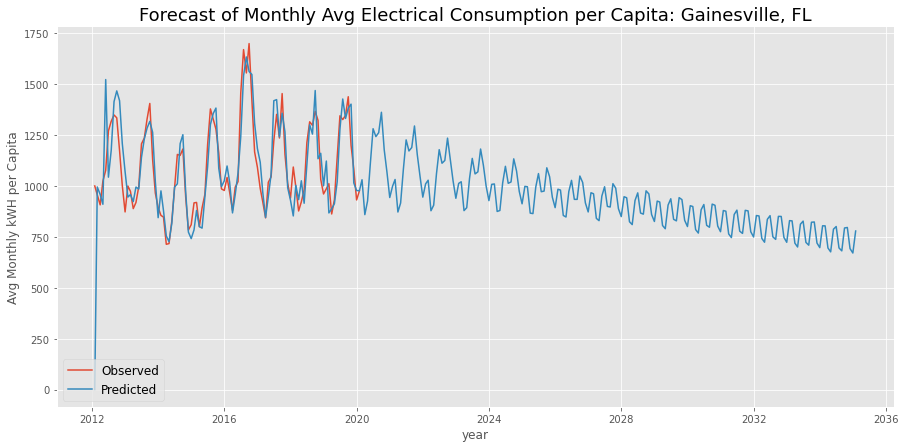

In [204]:
# Create a dataframe with index length of my prediction 
cov_rem.index = pd.to_datetime(cov_rem.index, infer_datetime_format=True)
index = pd.date_range(start='2020-02-28', end='2035-01-31', freq='M')
columns = ['avg_kwh_capita']
future_kwh = pd.DataFrame(index=index, columns=columns)

# Merge empty rediction df with the observed values df for endogenous factors in my model
future_kwh = future_kwh.merge(cov_rem, on='avg_kwh_capita', how='outer', left_index=True, right_index=True)

# Train a SARIMAX model with observed values 
e_consum_model = sm.tsa.statespace.SARIMAX(future_kwh, order=(0, 1, 2), seasonal_order=(2, 1, 1, 4)).fit()

# plot historical observations
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.plot(future_kwh.index, future_kwh)

# generate predictions from the start of observed data to city goal period 
preds = e_consum_model.get_prediction(start='2012-01-31', end='2035-01-31')

ax.plot(future_kwh.index, preds.predicted_mean)
ax.set_title("Forecast of Monthly Avg Electrical Consumption per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('year')
ax.set_ylabel('Avg Monthly kWH per Capita')
plt.legend(['Observed', 'Predicted'], loc=3, fontsize='large')
plt.savefig('images/pred_plot_diffed.png')

<h4>Plot a 95% confidence interval to 2035</h4

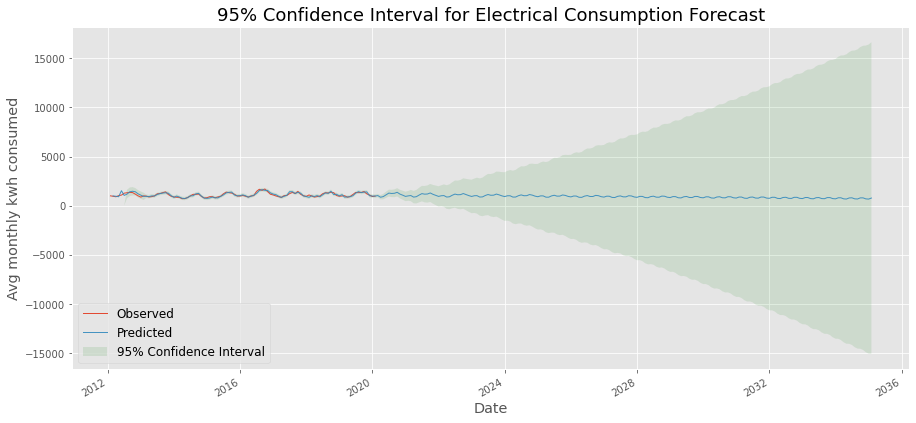

<Figure size 432x288 with 0 Axes>

In [205]:
# Generate plot of observed and predicted values with a 95% confidence interval

# specify number of forecasts
preds = e_consum_model.get_prediction(start='2012-02-28', end='2035-01-31')
pred_ci = preds.conf_int()

# replace lower bound large confidence interval values with 0 to better visualize
pred_ci['lower avg_kwh_capita'][0] = 0
pred_ci['lower avg_kwh_capita'][1] = 0
pred_ci['lower avg_kwh_capita'][2] = 0
pred_ci['lower avg_kwh_capita'][3] = 0
pred_ci['lower avg_kwh_capita'][4] = 0

# replace upper bound large confidence interval values with 0 to better visualize
pred_ci['upper avg_kwh_capita'][0] = 0
pred_ci['upper avg_kwh_capita'][1] = 0
pred_ci['upper avg_kwh_capita'][2] = 0
pred_ci['upper avg_kwh_capita'][3] = 0
pred_ci['upper avg_kwh_capita'][4] = 0

ax = future_kwh['2012-01-31':].plot(label='observed', linewidth=1.0)
preds.predicted_mean.plot(ax=ax, label='Forecast', alpha=.9, figsize=(15, 7), linewidth=1.0,)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("95% Confidence Interval for Electrical Consumption Forecast", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
plt.legend(['Observed', 'Predicted', '95% Confidence Interval'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('images/zoom_out_ci_diffed.png', dpi=100)

<h4>Plot a 95% confidence interval to 2022</h4

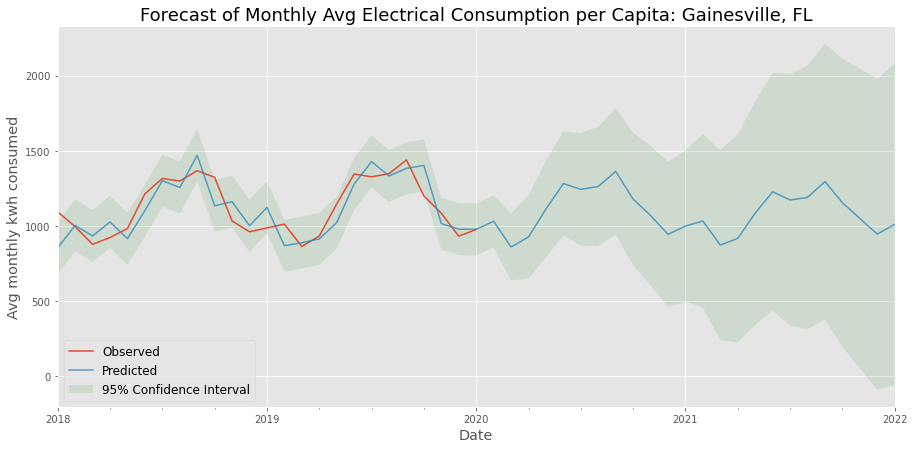

<Figure size 432x288 with 0 Axes>

In [149]:
# Zoom in where confidence interval more closely follows predictions

# specify number of forecasts
preds = e_consum_model.get_prediction(start='2018-01-31', end='2022-01-31', dynamic=False)
pred_ci = preds.conf_int()


ax = future_kwh['2018-01-31': '2022-01-31'].plot(label='observed')
preds.predicted_mean.plot(ax=ax, label='Forecast', alpha=.8, figsize=(15, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("Forecast of Monthly Avg Electrical Consumption per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg monthly kwh consumed', fontsize='x-large')
plt.legend(['Observed', 'Predicted', '95% Confidence Interval'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.savefig('images/pred_2022_diffed.png')
plt.show()
plt.draw()


<h4>Create a feature column for monthly average emissions per capita for 2020 to 2022</h4>

In [109]:
# Carbon intensity for grid electricity is 0.93184 lb/kwh
preds = preds.predicted_mean
preds = preds.to_frame()
preds_CO2 = preds
preds_CO2['avg_CO2_capita'] = preds_CO2['predicted_mean']*0.93184

In [110]:
# drop predicted electrcity consumption column
preds_CO2 = preds_CO2.drop(columns='predicted_mean')

<h4>Create a feature column for monthly average electrcity cost per capita 2020 to 2022</h4>

In [111]:
# Grid electricity cost in Gainesville is $.1293/kWh
preds_cost = preds
preds_cost['avg_cost_capita'] = preds['predicted_mean']*0.1293

In [112]:
# remove other columns
preds_cost = preds_cost.drop(columns=['predicted_mean','avg_CO2_capita'])

In [120]:
preds_cost.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 277 entries, 2012-01-31 to 2035-01-31
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_cost_capita  277 non-null    float64
dtypes: float64(1)
memory usage: 4.3 KB


<h4>Plot monthly average emissions per capita 2020 to 2022</h4>

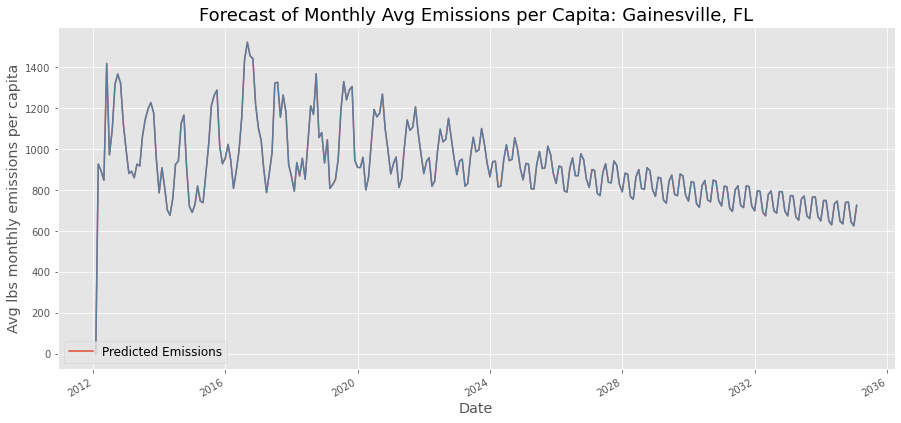

<Figure size 432x288 with 0 Axes>

In [113]:
# Zoom in where confidence interval more closely follows predictions

# specify number of forecasts
# preds = e_consum_model.get_prediction(start='2018-01-31', end='2022-01-31', dynamic=False)
# pred_ci = preds.conf_int()
# pred_ci = preds.conf_int()


ax = preds_CO2.plot(label='avg_CO2_capita')
preds_CO2.plot(ax=ax, label='Forecast', alpha=.8, figsize=(15, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("Forecast of Monthly Avg Emissions per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Avg lbs monthly emissions per capita', fontsize='x-large')
plt.legend(['Predicted Emissions'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.savefig('images/BAU_pred_emissions_2022.png')
plt.show()
plt.draw()


<h4>Plot monthly average grid-electricity cost per capita 2020 to 2022</h4>

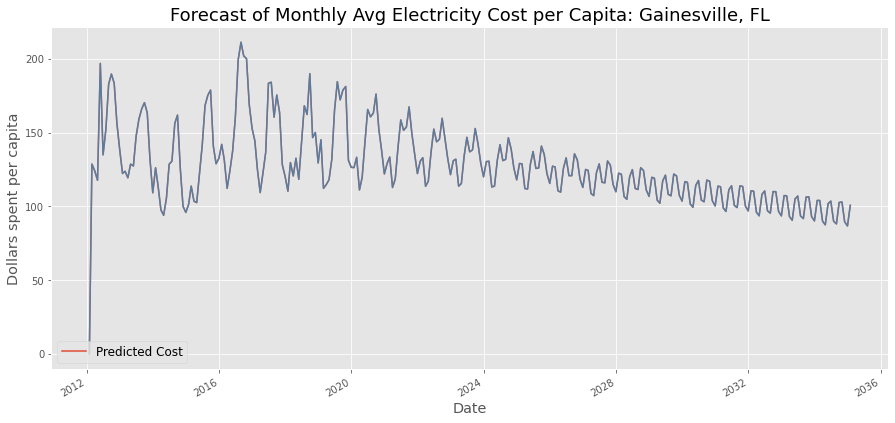

<Figure size 432x288 with 0 Axes>

In [114]:
# Zoom in where confidence interval more closely follows predictions

# specify number of forecasts
# preds = e_consum_model.get_prediction(start='2018-01-31', end='2022-01-31', dynamic=False)
# pred_ci = preds.conf_int()
# pred_ci = preds.conf_int()


ax = preds_cost.plot(label='avg_cost_capita')
preds_cost.plot(ax=ax, label='Forecast', alpha=.8, figsize=(15, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], facecolor='green', alpha=0.1)

ax.set_title("Forecast of Monthly Avg Electricity Cost per Capita: Gainesville, FL", fontsize=18)
ax.set_xlabel('Date', fontsize='x-large')
ax.set_ylabel('Dollars spent per capita', fontsize='x-large')
plt.legend(['Predicted Cost'], loc=3, fontsize='large')

fig1 = plt.gcf()
plt.savefig('images/BAU_pred_cost_2022.png')
plt.show()
plt.draw()


<h4>Generate ee improvements at different rates</h4>

In [227]:
#future_ee_reduct = preds['predicted_mean']

In [228]:
# add a column the length of my input data
pd.set_option('display.max_rows', None)
ee_reduction_2035 = 0.5

no_reductions = np.zeros(96)
ee_reductions = np.linspace(1, ee_reduction_2035, 181)
full_len = np.concatenate((no_reductions, ee_reductions), axis=0)
future_ee_reduct['0.5_ee_reduction'] = full_len
#future_ee_reduct

NameError: name 'future_ee_reduct' is not defined